# Deep dive of "mnist_epoch_8" model weights' alignment with order retraction plot

In [1]:
# basics
import os
import time
import numpy as np
import pandas as pd

# scipy and sklearn
from scipy.stats import entropy
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import seaborn as sns
from IPython.display import Image
from matplotlib.patches import Rectangle

# CMDGB
import graphviz
from CMGDB import PlotMorseSets, PlotMorseGraph

# local
from data_loaders import retrieve_predictions
from models import *
from utils import get_model_weights, convert_weight_dict_to_dataframe, compute_morse_graph, \
                  compute_morse_graph_with_gpflow_gp, compute_order_retraction, PlotOrderRetraction

sns.set()
plt.style.use('ggplot')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

Reading in predictions and weights for model runs with the "mnist_epoch_8" architecture, and obtaining morse graph and order retraction plot for inspection

In [3]:
interesting_mnist = "mnist_epoch_8"
smallest_or_largest = "largest"

In [4]:
y_test_mnist = np.array(pd.read_csv("y_test_mnist.csv"))
preds = retrieve_predictions(y_test=y_test_mnist, outdir="./data/mnist_epoch_8")

In [5]:
mnist_entropies = preds.groupby("point", as_index=False).agg({"p0": np.mean, "p1": np.mean})
mnist_entropies["entropy"] = mnist_entropies.apply(lambda x: entropy([x["p0"], x["p1"]]), axis=1)

[-0.2195934  -0.35602097]


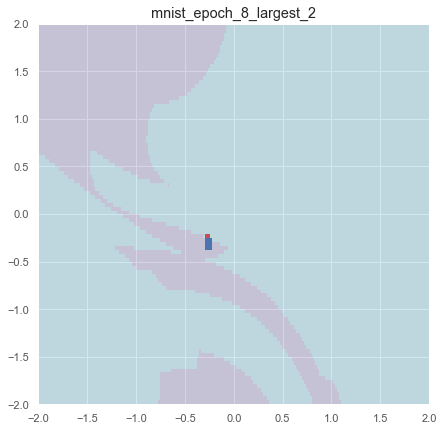

In [6]:
weights = get_model_weights("./data/{}".format(interesting_mnist))
weights = convert_weight_dict_to_dataframe(weights)

final_weights = weights.loc[weights["epoch"] != "1"]    
weight_cols = [c for c in list(final_weights.columns) if c not in ["model_id", "epoch", "val_loss"]]
std_df = pd.DataFrame(columns=["weight_name", "std"],
                      data=list(zip(weight_cols, [np.std(final_weights[col]) for col in weight_cols])))
std_df = std_df.sort_values(by="std")

if smallest_or_largest == "smallest":
    two_weights = list(std_df["weight_name"])[:2]
elif smallest_or_largest == "largest":
    two_weights = list(std_df["weight_name"])[-2:]
else:
    raise ValueError()

morseg, mapg = compute_morse_graph(weights[['epoch'] + two_weights], phase_subdiv=15)

compute_order_retraction(morseg, mapg, title="{}_{}_2".format(interesting_mnist, smallest_or_largest))

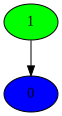

In [7]:
PlotMorseGraph(morseg)

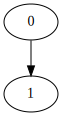

In [8]:
graphviz.Source.from_file('Hasse.dot')

In [9]:
morse_nodes_map = {1: 0, 0:1}  # manually set based on morse graph numbers above

In [10]:
with open('CMGDB_retract.txt','r') as infile:
    retract_indices = []
    retract_tiles = []
    for i in range(mapg.num_vertices()): 
        index, tile = [int(x) for x in next(infile).split()]
        retract_indices.append(index)
        retract_tiles.append(tile)

Obtaining weights from models with different numbers of epochs to see how the weights change visually when more or less epochs are used

In [11]:
weights_4_epochs = get_model_weights("./data/mnist_baseline")
weights_4_epochs = convert_weight_dict_to_dataframe(weights_4_epochs)
weights_4_epochs = weights_4_epochs[["model_id", "epoch", "val_loss"] + two_weights]

weights_8_epochs = get_model_weights("./data/mnist_epoch_8")
weights_8_epochs = convert_weight_dict_to_dataframe(weights_8_epochs)
weights_8_epochs = weights_8_epochs[["model_id", "epoch", "val_loss"] + two_weights]

weights_12_epochs = get_model_weights("./data/mnist_epoch_12")
weights_12_epochs = convert_weight_dict_to_dataframe(weights_12_epochs)
weights_12_epochs = weights_12_epochs[["model_id", "epoch", "val_loss"] + two_weights]

weights_16_epochs = get_model_weights("./data/mnist_epoch_16")
weights_16_epochs = convert_weight_dict_to_dataframe(weights_16_epochs)
weights_16_epochs = weights_16_epochs[["model_id", "epoch", "val_loss"] + two_weights]

In [12]:
# This block is just to figure out which weight corresponds to which axis in the order retraction plot

print(two_weights[0])
print("min", weights_16_epochs[two_weights[0]].min() - 0.5)
print("max", weights_16_epochs[two_weights[0]].max() + 0.5)
print()
print(two_weights[1])
print("min", weights_16_epochs[two_weights[1]].min() - 0.5)
print("max", weights_16_epochs[two_weights[1]].max() + 0.5)

dense_kernel_0_3
min -2.718585968017578
max 2.4002586603164673

dense_kernel_0_13
min -3.347527027130127
max 2.276892900466919


Plotting order retractions with weights at different epochs superimposed to visually see how weights change

In [13]:
# PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
#                     df_of_interest=weights_4_epochs, x=two_weights[0], y=two_weights[1], hue="epoch")

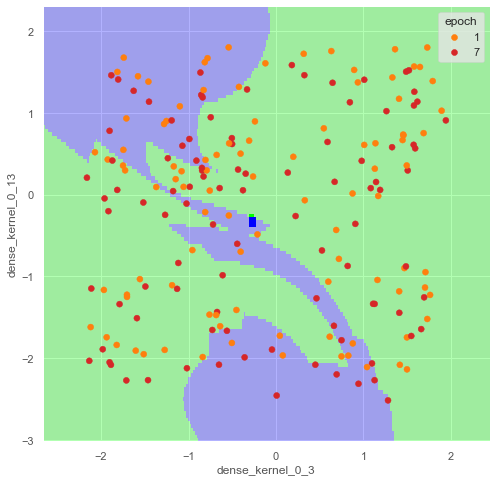

In [14]:
PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
                    df_of_interest=weights_8_epochs, x=two_weights[0], y=two_weights[1], hue="epoch")

In [15]:
# PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
#                     df_of_interest=weights_12_epochs, x=two_weights[0], y=two_weights[1], hue="epoch")

In [16]:
# PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
#                     df_of_interest=weights_16_epochs, x=two_weights[0], y=two_weights[1], hue="epoch")

Splitting up weights at epoch 8 into weights that are inside the blue region and points that are inside the green region

In [17]:
inside_outside_df = weights_8_epochs.copy()
inside_outside_df = inside_outside_df.loc[inside_outside_df["epoch"] == "1"].reset_index(drop=True)
inside_outside_df = inside_outside_df.drop(columns="epoch")
inside_outside_df["inside_outside"] = "inside"
inside_outside_df["inside_outside"][0] = "outside"

inside_outside_df.loc[inside_outside_df["dense_kernel_0_3"] > 1.1, "inside_outside"] = "outside"

inside_outside_df.loc[(inside_outside_df["dense_kernel_0_3"] > 0.15) & 
                      (inside_outside_df["dense_kernel_0_13"] > -1.5), 
                      "inside_outside"] = "outside"
inside_outside_df.loc[(inside_outside_df["dense_kernel_0_3"] < -0.6) & 
                      (inside_outside_df["dense_kernel_0_13"] < -0.5), 
                      "inside_outside"] = "outside"

inside_outside_df["inside_outside"][2] = "outside"
inside_outside_df["inside_outside"][5] = "outside"
inside_outside_df["inside_outside"][10] = "outside"
inside_outside_df["inside_outside"][16] = "outside"
inside_outside_df["inside_outside"][23] = "outside"
inside_outside_df["inside_outside"][25] = "outside"
inside_outside_df["inside_outside"][31] = "outside"
inside_outside_df["inside_outside"][34] = "outside"
# inside_outside_df["inside_outside"][37] = "outside"
inside_outside_df["inside_outside"][42] = "outside"
inside_outside_df["inside_outside"][44] = "outside"
inside_outside_df["inside_outside"][46] = "outside"
inside_outside_df["inside_outside"][47] = "outside"
inside_outside_df["inside_outside"][56] = "outside"
inside_outside_df["inside_outside"][65] = "outside"
inside_outside_df["inside_outside"][71] = "outside"
inside_outside_df["inside_outside"][74] = "outside"
inside_outside_df["inside_outside"][81] = "outside"
inside_outside_df["inside_outside"][82] = "outside"
inside_outside_df["inside_outside"][85] = "outside"
inside_outside_df["inside_outside"][90] = "outside"
inside_outside_df["inside_outside"][92] = "outside"

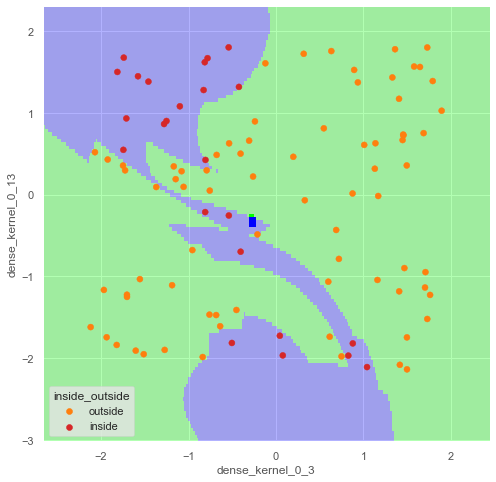

In [18]:
# Plotting weights again to make sure they were split up correctly in the previous block
PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map,
                    df_of_interest=inside_outside_df, x=two_weights[0], y=two_weights[1], hue="inside_outside")

Creating two separate DataFrames for weights that ended up in the blue region and weights that ended up in the green region

In [19]:
labeled_weights = pd.merge(weights_8_epochs, inside_outside_df[["model_id", "inside_outside"]])

In [20]:
inside_final_weights = labeled_weights.loc[labeled_weights["inside_outside"] == "inside"]
inside_final_weights = inside_final_weights.loc[inside_final_weights["epoch"] != "1"]
outside_final_weights = labeled_weights.loc[labeled_weights["inside_outside"] == "outside"]
outside_final_weights = outside_final_weights.loc[outside_final_weights["epoch"] != "1"]

In [21]:
inside_final_weights.shape

(24, 6)

In [22]:
outside_final_weights.shape

(76, 6)

In [23]:
outside_final_weights

,model_id,epoch,val_loss,dense_kernel_0_3,dense_kernel_0_13,inside_outside
0,model.68,7,61.67,1.097388,-2.063008,outside
3,model.58,7,173.70,-2.161798,0.206753,outside
7,model.50,7,5.04,-0.377799,0.052948,outside
9,model.81,7,1.09,0.670176,0.156026,outside
11,model.86,7,7.83,-1.130806,-1.151775,outside
...,...,...,...,...,...,...
186,model.57,7,42.38,-0.433933,0.305967,outside
190,model.44,7,6.76,0.462790,-1.267280,outside
192,model.77,7,34.43,0.134614,0.268493,outside
195,model.62,7,16.83,1.546667,-1.727477,outside


Calculating entropies for models that had weights end up in the blue region at epoch 8 vs. models that had weights end up in the green region at epoch 8

In [24]:
inside_preds = pd.merge(preds, inside_outside_df[["model_id", "inside_outside"]], 
                        left_on="model", right_on="model_id").drop(columns="model_id")
outside_preds = pd.merge(preds, inside_outside_df[["model_id", "inside_outside"]], 
                         left_on="model", right_on="model_id").drop(columns="model_id")
inside_preds = inside_preds.loc[inside_preds["inside_outside"] == "inside"]
outside_preds = outside_preds.loc[outside_preds["inside_outside"] == "outside"]

In [25]:
inside_entropies = inside_preds.groupby("point", as_index=False).agg({"p0": np.mean, "p1": np.mean})
inside_entropies["entropy"] = inside_entropies.apply(lambda x: entropy([x["p0"], x["p1"]]), axis=1)

outside_entropies = outside_preds.groupby("point", as_index=False).agg({"p0": np.mean, "p1": np.mean})
outside_entropies["entropy"] = outside_entropies.apply(lambda x: entropy([x["p0"], x["p1"]]), axis=1)

inside_entropies["Models"] = "Blue"
outside_entropies["Models"] = "Green"
mnist_entropies["Models"] = "All"

In [26]:
all_entropies = pd.concat([mnist_entropies, inside_entropies, outside_entropies])

Plotting calculated entropies

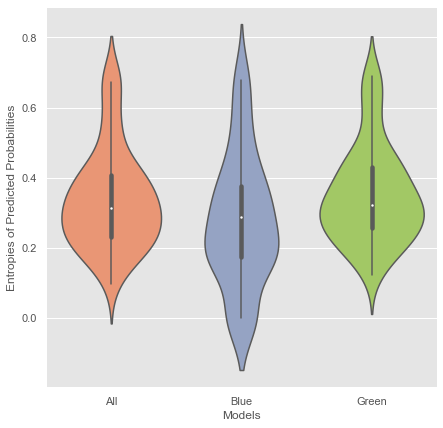

In [27]:
hex_vals = sns.color_palette("Set2").as_hex()
plt.figure(figsize=(7, 7))
sns.violinplot(data=all_entropies, y="entropy", x="Models", 
               palette=sns.color_palette([hex_vals[1], hex_vals[2], hex_vals[4]]))
plt.ylabel("Entropies of Predicted Probabilities")


SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Calculating accuracies for models that had weights end up in the blue region at epoch 8 vs. models that had weights end up in the green region at epoch 8

In [28]:
mnist_accuracies = preds.groupby("model", as_index=False
                                          ).apply(lambda x: balanced_accuracy_score(x["pred_class"], 
                                                                                    x["real_class"]))
mnist_accuracies = mnist_accuracies.reset_index(drop=True).rename(columns={None: "mean_balanced_accuracy"})

In [29]:
inside_accuracies = inside_preds.groupby("model", as_index=False
                                          ).apply(lambda x: balanced_accuracy_score(x["pred_class"], 
                                                                                    x["real_class"]))
inside_accuracies = inside_accuracies.reset_index(drop=True).rename(columns={None: "mean_balanced_accuracy"})

In [30]:
outside_accuracies = outside_preds.groupby("model", as_index=False
                                          ).apply(lambda x: balanced_accuracy_score(x["pred_class"], 
                                                                                    x["real_class"]))
outside_accuracies = outside_accuracies.reset_index(drop=True).rename(columns={None: "mean_balanced_accuracy"})

In [31]:
inside_accuracies["Models"] = "Blue"
outside_accuracies["Models"] = "Green"
mnist_accuracies["Models"] = "All"

all_accuracies = pd.concat([mnist_accuracies, inside_accuracies, outside_accuracies])

Plotting calculated accuracies

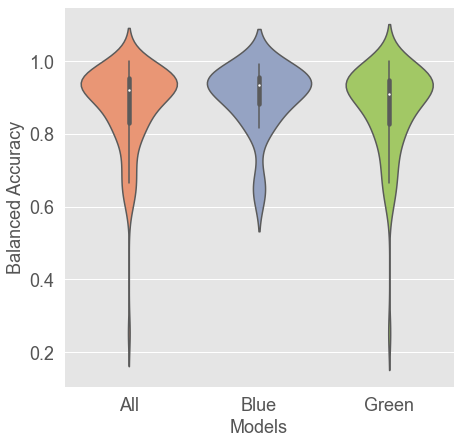

In [32]:
hex_vals = sns.color_palette("Set2").as_hex()
plt.figure(figsize=(7, 7))
sns.violinplot(data=all_accuracies, y="mean_balanced_accuracy", x="Models", 
               palette=sns.color_palette([hex_vals[1], hex_vals[2], hex_vals[4]]))
plt.ylabel("Balanced Accuracy")


SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title